<a href="https://colab.research.google.com/github/padibi4/cap-comp215/blob/main/Flab06_GoL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name: Paniz
#### Date:

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [ ]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [ ]:
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [ ]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [ ]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

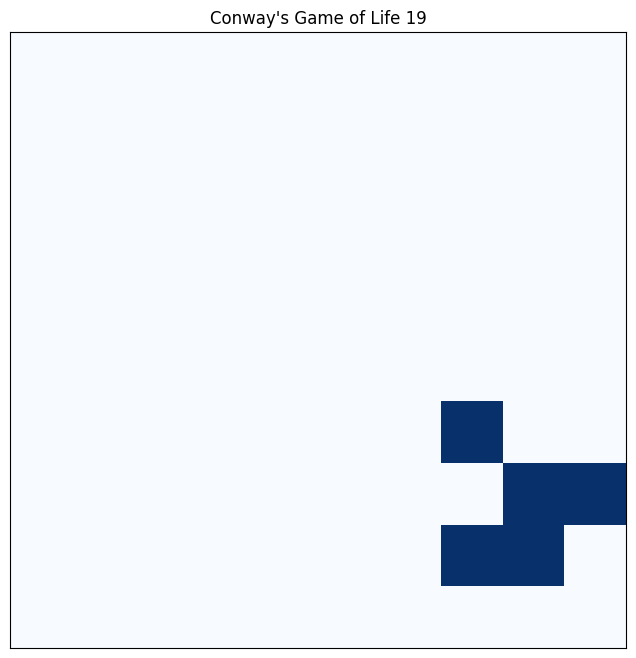

In [ ]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
Write a line or 2 of code to compute and print the answer for each question:
* how many unique states are there for a 3x3 (9 cell) neighbourhood?
* how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
* how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)

**Hi Joseph, I hope my codes don't freak you out with the way I put a comment after each line of code.I tried to explain what each line does so it could help me remember and have a better understanding of these codes when I try to write them again! The codes are done by myself I just got help to finish up question 3 with AI because I kept getting errors but I understood the errors after!**

In [ ]:
# Ex. 1 your code here...
# question 1
number_of_sells= 9  #initialized a cell number
possibilities= 2 # initialized the number of possibilities

unique_states= possibilities ** number_of_sells #initialize a value that take the possibilities for each cell and raise it to the power of 9.
print(unique_states) # prints out the final result of this math operation (2 ^ 9)

#question 2
def unique_rules(size, num_states): # defining a function which takes the size and the number of states to count how many rules there are.
    return num_states **(2 ** size) # the function ought to return num_states^ (2^size)

size= 3 #initialized size is 3
num_states = 2 # initialized num states is 2 around the centre cell
total_rules = unique_rules(size, num_states) # finally it defines another value where it does the calculation of these two elements and store it on its name.

print("Total number of unique rules are:", total_rules)
#question 3
mass_of_ordinary_matter= 1.45 * (10**53)
mass_of_hydrogen_atoms = 1.67 * (10**-27)
number_of_atoms_in_observable_universe= mass_of_ordinary_matter / mass_of_hydrogen_atoms
# number_of_atoms_in_observable_universe_2= number_of_atoms_in_observable_universe [:3]
# "dividing the mass of ordinary matter by the mass of a hydrogen atom."
print(number_of_atoms_in_observable_universe)


512
Total number of unique rules are: 256
8.682634730538921e+79


Using what you learned above, concisely answer each question below (point form)1
1. would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
2. propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
3. how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

#### Ex 1. Your Answers

1. . Yes it would.
2. .A numbering scheme for 2D cellular automata can be similar to Wolfram's rule numbers, where each rule is represented by an 8-digit binary number. The number of neighbors depends on the neighborhood type. For example, this scheme uses binary sequences of length 8 to represent neighborhood configurations, with corresponding decimal numbers as rule numbers, providing a systematic method for enumerating and referencing rules.
3. Define the neighborhood configuration for each rule according to Conway's GoL rules.
Look for the rule number that matches this configuration within the numbering scheme we generated.

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in previous lab

In [ ]:
# Ex. 2 experimental setup
import random
class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        for i in range(self.rows):
          for b in range (self.cols):
            if random.random() < p:
              self.array[i][b]= 1
            else:
              self.array[i][b]=0


def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    if n_cols is None:
        n_cols = n_rows
    life = BetterLife2D(n_rows, n_cols)
    life.randomize_state(p)
    return life

### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

In [ ]:
# Ex. 2 write code for your experiment here...

In [ ]:
import random
import numpy as np
from scipy.signal import convolve2d

class BetterLife2D:
    """ Improvements on the basic Life2D model """

    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.array = np.zeros((rows, cols), dtype=int)

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        for i in range(self.rows):
            for j in range(self.cols):
                if random.random() < p:
                    self.array[i][j] = 1

    def update(self):
        """ Update the state of the GoL grid according to the rules """
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]])
        neighbor_count = convolve2d(self.array, kernel, mode='same', boundary='wrap')
        self.array = np.where(np.logical_or(neighbor_count == 3, np.logical_and(self.array == 1, neighbor_count == 2)), 1, 0)

    def is_stable(self):
        """ Check if the grid has stabilized """
        return np.all(self.array == 0) or np.all(self.array == 1)

def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    if n_cols is None:
        n_cols = n_rows
    life = BetterLife2D(n_rows, n_cols)
    life.randomize_state(p)
    return life

def time_to_stabilize(p, n_rows, n_cols, max_iterations=1000):
    """ Simulate GoL with random initial state with probability p and return time steps to stabilize """
    life = random_life(n_rows, n_cols, p)
    for t in range(max_iterations):
        life.update()
        if life.is_stable():
            return t + 1  # Adding 1 because t starts from 0
    return max_iterations  # Return max_iterations if stabilization not reached within the limit

# Experiment setup
p_values = [0.1, 0.3, 0.5, 0.7, 0.9]  # Different probability values
n_rows = 20  # Grid dimensions
n_cols = 20

# Run experiment for each probability value
for p in p_values:
    times = [time_to_stabilize(p, n_rows, n_cols) for _ in range(10)]  # Run 10 simulations for each probability
    avg_time = np.mean(times)
    print(f"Probability (p = {p}): Average stabilization time = {avg_time}")


Probability (p = 0.1): Average stabilization time = 602.6
Probability (p = 0.3): Average stabilization time = 916.7
Probability (p = 0.5): Average stabilization time = 1000.0
Probability (p = 0.7): Average stabilization time = 900.4
Probability (p = 0.9): Average stabilization time = 1.2


## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add a `load_pattern(x, y, pattern)` method to your `BetterLife2D` class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [ ]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """

# Ex. 3 your code here...

In [ ]:
import numpy as np
from scipy.signal import convolve2d

class BetterLife2D:
    """Improvements on the basic Life2D model."""

    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.array = np.zeros((rows, cols), dtype=int)

    def randomize_state(self, p):
        """Randomize the state of this GoL, where probability of a "live" cell is p."""
        self.array = np.random.choice([0, 1], size=(self.rows, self.cols), p=[1 - p, p])

    def update(self):
        """Update the state of the GoL grid according to the rules."""
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]])
        neighbor_count = convolve2d(self.array, kernel, mode='same', boundary='wrap')
        self.array = np.where(np.logical_or(neighbor_count == 3, np.logical_and(self.array == 1, neighbor_count == 2)),
                              1, 0)

    def is_stable(self):
        """Check if the grid has stabilized."""
        return np.all(self.array == 0) or np.all(self.array == 1)

    def load_pattern(self, x, y, pattern):
        """Load a pattern into the Life state array at position (x, y)."""
        pattern_array = self.parse_pattern(pattern)
        pattern_rows, pattern_cols = pattern_array.shape
        self.array[x:x + pattern_rows, y:y + pattern_cols] = pattern_array

    @staticmethod
    def parse_pattern(pattern):
        """Parse the pattern string into a 2D array."""
        lines = pattern.strip().split('\n')
        rows = len(lines)
        cols = max(len(line) for line in lines)
        pattern_array = np.zeros((rows, cols), dtype=int)
        for i, line in enumerate(lines):
            for j, char in enumerate(line):
                if char == '1':
                    pattern_array[i, j] = 1
        return pattern_array


In [ ]:
life = BetterLife2D(10, 10)
life.load_pattern(2, 2, """
001
011
111
""")
print(life.array)


[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

 **This piece of code used to work perfectly and had the same output as the one below it. I tried to fix it with Chatgpt and it gave me the full long code. I will try to figure out how to fix the short code below to get my previous result. **

In [ ]:
# life = BetterLife2D(20, 20)
# life.load_pattern(5, 5, patterns['Glider'])
# life.load_pattern(10, 10, patterns['Lightweight Spaceship (LWSS)'])
# life.load_pattern(0, 0, patterns['Beacon'])
# print(life.array)


In [ ]:
import numpy as np
from scipy.signal import convolve2d

class BetterLife2D:
    """Improvements on the basic Life2D model."""

    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.array = np.zeros((rows, cols), dtype=int)

    def randomize_state(self, p):
        """Randomize the state of this GoL, where probability of a "live" cell is p."""
        self.array = np.random.choice([0, 1], size=(self.rows, self.cols), p=[1 - p, p])

    def update(self):
        """Update the state of the GoL grid according to the rules."""
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]])
        neighbor_count = convolve2d(self.array, kernel, mode='same', boundary='wrap')
        self.array = np.where(np.logical_or(neighbor_count == 3, np.logical_and(self.array == 1, neighbor_count == 2)),
                              1, 0)

    def is_stable(self):
        """Check if the grid has stabilized."""
        return np.all(self.array == 0) or np.all(self.array == 1)

    def load_pattern(self, x, y, pattern):
        """Load a pattern into the Life state array at position (x, y)."""
        pattern_array = self.parse_pattern(pattern)
        pattern_rows, pattern_cols = pattern_array.shape
        self.array[x:x + pattern_rows, y:y + pattern_cols] = pattern_array

    @staticmethod
    def parse_pattern(pattern):
        """Parse the pattern string into a 2D array."""
        lines = pattern.strip().split('\n')
        rows = len(lines)
        cols = max(len(line) for line in lines)
        pattern_array = np.zeros((rows, cols), dtype=int)
        for i, line in enumerate(lines):
            for j, char in enumerate(line):
                if char == '1':
                    pattern_array[i, j] = 1
        return pattern_array

# Define patterns within the scope of BetterLife2D class
glider = """
010
001
111
"""

lwss = """
0001
1000
1001
1111
"""

beacon = """
11
11
00
00
"""

# Define patterns dictionary
patterns = {
    'Glider': glider,
    'Lightweight Spaceship (LWSS)': lwss,
    'Beacon': beacon
}

# Usage example
life = BetterLife2D(20, 20)
life.load_pattern(5, 5, patterns['Glider'])
life.load_pattern(10, 10, patterns['Lightweight Spaceship (LWSS)'])
life.load_pattern(0, 0, patterns['Beacon'])
print(life.array)


[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

These patterns evolve according to Conway's Game of Life rules, revealing some real-world phenomena like population dynamics and chemical reactions. Studying cellular automata interactions could be useful in complex systems' behavior, self-organization in biological, social, and technological systems, as well as studying disease spread and atomic level behavior.

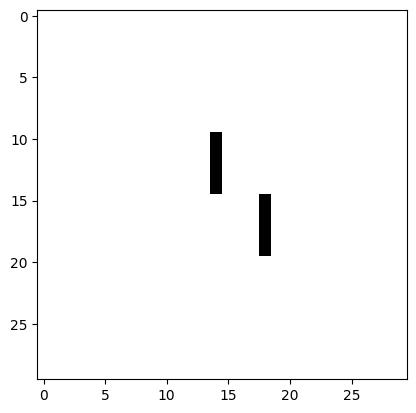

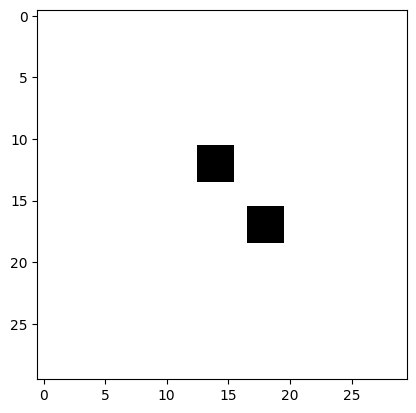

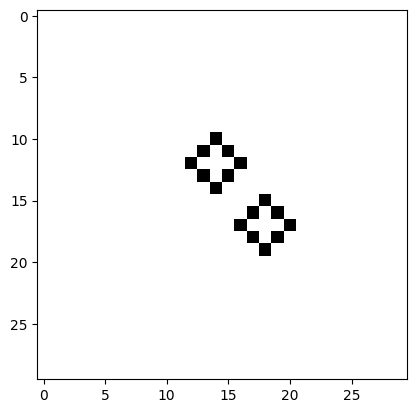

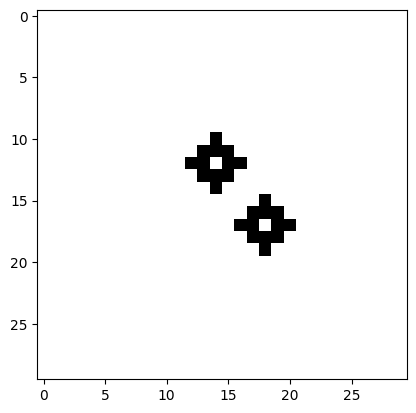

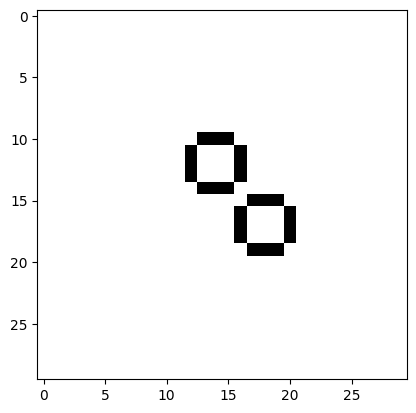

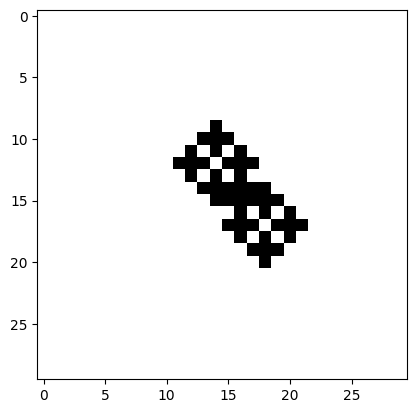

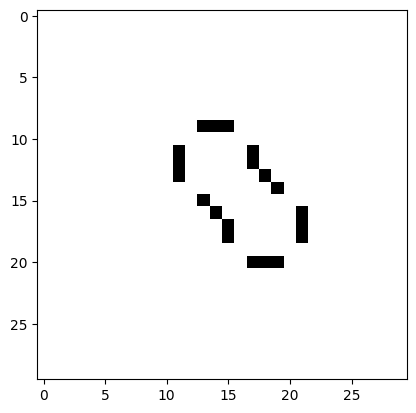

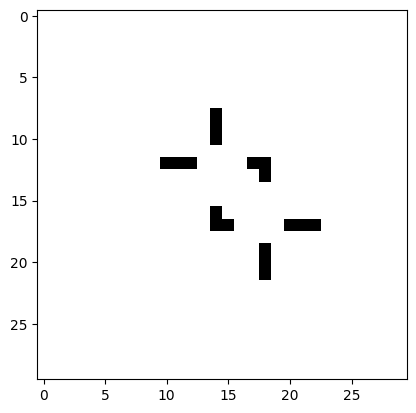

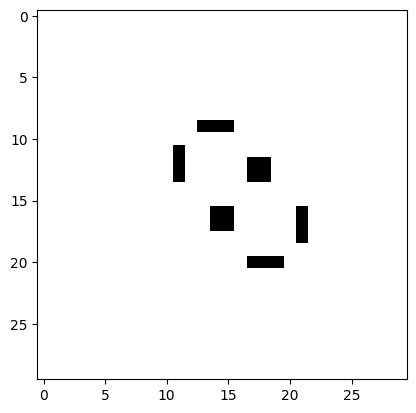

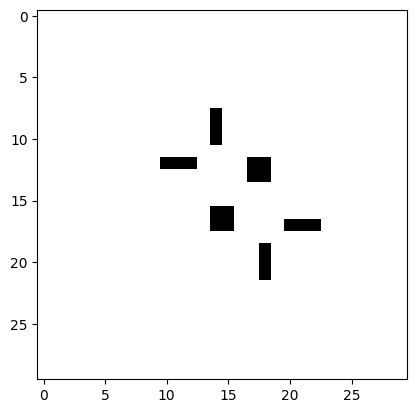

In [ ]:


# Ex. 3 code for your experiment here
import matplotlib.pyplot as plt

# Define the size of the grid
rows = 30
cols = 30

# Create a BetterLife2D object
life = BetterLife2D(rows, cols)

# Load patterns into the grid
life.load_pattern(10, 10, """
00001
00001
00001
00001
00001
""")
life.load_pattern(15, 15, """
00010
00010
00010
00010
00010
""")

# Run the simulation for some time steps
for _ in range(10):
    plt.imshow(life.array, cmap='binary')
    plt.show()
    life.update()
